In [1]:
import json
import typing as t

# data prep
import pandas as pd
import numpy as np

# for creating image vector embeddings
from PIL import Image
from img2vec_pytorch import Img2Vec

# for creating semantic (text-based) vector embeddings
from sentence_transformers import SentenceTransformer

# plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
DATA_PATH = "fashion-dataset"

# load in data and clean data types and drop null rows
metadata = pd.read_csv(DATA_PATH + "/styles.csv", on_bad_lines='skip')
metadata.dropna(inplace=True)
metadata["year"] = metadata["year"].astype(int)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44077 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44077 non-null  int64 
 1   gender              44077 non-null  object
 2   masterCategory      44077 non-null  object
 3   subCategory         44077 non-null  object
 4   articleType         44077 non-null  object
 5   baseColour          44077 non-null  object
 6   season              44077 non-null  object
 7   year                44077 non-null  int64 
 8   usage               44077 non-null  object
 9   productDisplayName  44077 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.7+ MB


In [7]:
# check out some of the JSON data.
data = json.loads(open(DATA_PATH + "/styles/6041.json", "r").read())
data

{'notification': {},
 'meta': {'code': 200, 'requestId': '832d54ee-d88b-4f34-a962-26321d73691c'},
 'data': {'id': 6041,
  'price': 1499,
  'discountedPrice': 1499,
  'styleType': 'P',
  'productTypeId': 289,
  'articleNumber': '11P3084J0926I203',
  'visualTag': '',
  'productDisplayName': "UCB Men's Polo Neck With Lion Logo Navy Blue T-shirt",
  'variantName': 'H/S Polo Neck t-Shirt with Lion Logo',
  'myntraRating': 0,
  'catalogAddDate': 1446705981,
  'brandName': 'United Colors of Benetton',
  'ageGroup': 'Adults-Men',
  'gender': 'Men',
  'baseColour': 'Navy Blue',
  'colour1': '',
  'colour2': '',
  'fashionType': 'Fashion',
  'season': 'Summer',
  'year': '2011',
  'usage': 'Casual',
  'vat': 5.5,
  'displayCategories': 'Casual Wear,Sale',
  'weight': '0',
  'navigationId': 0,
  'landingPageUrl': 'Tshirts/United-Colors-of-Benetton/UCB-Mens-Polo-Neck-With-Lion-Logo-Navy-Blue-T-shirt/6041/buy',
  'articleAttributes': {'Body or Garment Size': 'Garment Measurements in'},
  'crossLink

In [8]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


In [9]:
product_data = metadata.sample(40000)
product_data

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
43573,2494,Men,Footwear,Flip Flops,Flip Flops,White,Fall,2010,Casual,Numero Uno Men's Casual White Flip Flop
40266,19556,Women,Apparel,Topwear,Tshirts,White,Summer,2011,Casual,United Colors of Benetton Women Solid White Po...
12641,24362,Women,Apparel,Topwear,Kurtas,Brown,Fall,2011,Ethnic,Folklore Women Brown Printed Kurta
37058,4619,Women,Apparel,Topwear,Tops,White,Summer,2011,Casual,Jealous 21 Women Design White Top
4254,26794,Men,Apparel,Topwear,Shirts,Grey,Summer,2013,Formal,Arrow Men Grey Shirt
...,...,...,...,...,...,...,...,...,...,...
1982,58320,Men,Accessories,Socks,Socks,White,Summer,2016,Sports,Jockey LCESCBRA Men White Pack of 3 Socks 2004
36120,37580,Girls,Apparel,Bottomwear,Shorts,Pink,Winter,2012,Casual,Madagascar 3 Girls Pink Shorts
16840,57141,Women,Apparel,Bottomwear,Trousers,Olive,Summer,2012,Casual,Elle Women Olive Trousers
276,31120,Girls,Apparel,Topwear,Tops,Pink,Summer,2012,Casual,Palm Tree Girls Pink Top


In [10]:
product_meta = []
for index, row in metadata.iterrows():
    product = {"id": row["id"]}
    json_file = DATA_PATH + "/styles/" + str(row["id"]) + ".json"
    # open and read json data
    json_data = json.loads(open(json_file, "r").read())["data"]
    # extract relevant data
    product["brand"] = json_data["brandName"]
    product["age_group"] = json_data["ageGroup"]
    try:
        product["description"] = strip_tags(json_data["productDescriptors"]["description"]["value"])
        product["image_url"] = json_data["styleImages"]["default"]["imageURL"]
        product_meta.append(product)
    except KeyError:
        continue

product_meta_from_json = pd.DataFrame(product_meta)
product_meta_from_json

,id,brand,age_group,description,image_url
0,15970,Turtle,Adults-Men,CompositionDark brown and indigo blue plaid ch...,http://assets.myntassets.com/v1/images/style/p...
1,39386,Peter England,Adults-Men,Style Note Look cool and casual in these jeans...,http://assets.myntassets.com/v1/images/style/p...
2,59263,Titan,Adults-Women,Silver steel case with a fixed bezel for durab...,http://assets.myntassets.com/v1/images/style/p...
3,21379,Manchester United,Adults-Men,Composition Black Official Merchandise manches...,http://assets.myntassets.com/v1/images/style/p...
4,53759,Puma,Adults-Men,Grey knit polo T-shirt with moisture managemen...,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...
44003,17036,GAS,Adults-Men,Have fun choosing from a collection of sneaker...,http://assets.myntassets.com/v1/images/style/p...
44004,6461,Lotto,Adults-Men,Get ready for that long overdue trip to the be...,http://assets.myntassets.com/v1/images/style/p...
44005,18842,Puma,Adults-Men,"Composition Blue T-shirt made of 100% cotton, ...",http://assets.myntassets.com/v1/images/style/p...
44006,46694,Rasasi,Adults-Women,Style Note rasasi impresses and flatters your ...,http://assets.myntassets.com/v1/images/style/p...


(array([21817.,     0., 18125.,     0.,  1063.,     0.,   847.,     0.,
         1887.,   269.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

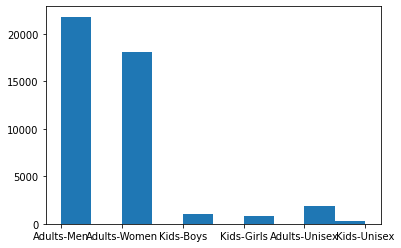

In [8]:
# plot the distribution of the age group
plt.hist(product_meta_from_json["age_group"])

In [11]:
all_product_data = pd.merge(product_meta_from_json, metadata, on="id", how="left")
all_product_data

,id,brand,age_group,description,image_url,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Turtle,Adults-Men,CompositionDark brown and indigo blue plaid ch...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Peter England,Adults-Men,Style Note Look cool and casual in these jeans...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Titan,Adults-Women,Silver steel case with a fixed bezel for durab...,http://assets.myntassets.com/v1/images/style/p...,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Manchester United,Adults-Men,Composition Black Official Merchandise manches...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Puma,Adults-Men,Grey knit polo T-shirt with moisture managemen...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44003,17036,GAS,Adults-Men,Have fun choosing from a collection of sneaker...,http://assets.myntassets.com/v1/images/style/p...,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013,Casual,Gas Men Caddy Casual Shoe
44004,6461,Lotto,Adults-Men,Get ready for that long overdue trip to the be...,http://assets.myntassets.com/v1/images/style/p...,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011,Casual,Lotto Men's Soccer Track Flip Flop
44005,18842,Puma,Adults-Men,"Composition Blue T-shirt made of 100% cotton, ...",http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,Puma Men Graphic Stellar Blue Tshirt
44006,46694,Rasasi,Adults-Women,Style Note rasasi impresses and flatters your ...,http://assets.myntassets.com/v1/images/style/p...,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017,Casual,Rasasi Women Blue Lady Perfume


In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robert.shelton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import re
import string
from nltk.corpus import stopwords

eng_stopwords = stopwords.words("english")

# use regex to remove all words after the word "Material"
def clean_description(description):
    if not description:
        return ""
    # remove unicode characters
    description = description.encode('ascii', 'ignore').decode()

    # remove punctuation
    description = re.sub('[%s]' % re.escape(string.punctuation), ' ', description)

    # clean up the spacing
    description = re.sub('\s{2,}', " ", description)

    # remove urls
    description = re.sub("https*\S+", " ", description)

    # remove newlines
    description = description.replace("\n", " ")

    # remove all numbers
    description = re.sub('\w*\d+\w*', '', description)

    # split on capitalized words
    description = " ".join(re.split('(?=[A-Z])', description))

    # remove all words after the word "Material"
    description = re.sub("Material.*", "", description)

    # remove all words after the word "Model"
    description = re.sub("Model.*", "", description)

    # remove the words "wash" "Hand", "Hand Wash", "Hand Washable", "Hand Washable", "cold", "degrees", "detergent", "wring", "bleach", "iron"
    description = re.sub("wash|Hand|Hand Wash|Hand Washable|Hand Washable|cold|degrees|detergent|wring|bleach|iron", "", description)

    # clean up the spacing again
    description = re.sub('\s{2,}', " ", description)

    # make all words lowercase
    description = description.lower()

    # remove stop words (debating whether to include this)
    description = " ".join([word for word in description.split() if word not in eng_stopwords])

    return description

clean_description(all_product_data.description[4])

'grey knit polo shirt moisture management technology keep dry ribbed spread collar short buttoned placket short raglan sleeves mesh panel running sleeve side brand logo appliqued chest straight hem front curved hem back'

In [14]:
all_product_data["description"] = all_product_data.description.apply(clean_description)
all_product_data.description[5]

'cotton shirt depicts typical indian ness cannot found anywhere world india people live unconditional harmony land nice fabrics cool colours easy relaxed fit things come mind one thinks shirts little kids college goers young oldies everybody loves shirts perfect casual wear ever created man easy wear comfortable popularity shirts soaring seems life without shirt unthinkable holds barred addiction people get rid multitude colours designs fits sizes shirts come tribute astounding craze shirts eternal favourite one go shirts right away'

In [16]:
# Resnet-18 to create image embeddings
img2vec = Img2Vec(cuda=False)

# bert variant to create text embeddings
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnin

In [17]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.0,
                     stop_words='english')
tfidf_matrix = tf.fit_transform(all_product_data['description'])

In [20]:
tfidf_matrix.shape

(44008, 216970)

In [21]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [19]:
# write function to get recommendations based on cosine similarity
prods = all_product_data.reset_index()
prod_names = prods['productDisplayName']
indices = pd.Series(prods.index, index=prods['productDisplayName'])

def get_recommendations(product_name):
    try:
        # handle duplicates
        idx = indices[product_name][0]
    except IndexError:
        idx = indices[product_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:15]
    product_indicies = [i[0] for i in sim_scores]
    return prod_names.iloc[product_indicies]

In [20]:
index = 200
name= prods.iloc[index].name
desc = prods.iloc[index].description
print("Name:", name, "\nDescription:", desc)

Name: 200 
Description: crafted superior quality leather designed practicality wallet newhide makes perfect everyday wallet open width cm height cm made pure leather brand name embossed outer one zippered compartment one open compartment left right flaps card holders compartment side care wipe surface clean dry cloth remove dust


In [21]:
get_recommendations(name)

6251                  Lino Perros Women Solid Grey Wallet
8173    United Colors of Benetton Women Solid Coffee B...
6455                   Wrangler Leather Men Brown Wallets
542     United Colors of Benetton Women Solid DK.Grey ...
5377                Lino Perros Women Solid Brown Handbag
9846        Spice Art Women Gold Embroidery Purple Clutch
8456                           Murcia Women Brown Handbag
8771                     Newhide Brown Men Antique Wallet
5544                      Newhide Black Men Casual Wallet
6131                       Lino Perros Women Green Wallet
9183                         Lino Perros Women Red Wallet
3469                    Fastrack Women Leather Red Wallet
9282                             Newhide Authentic Wallet
7996            Lino Perros Purple Women Casual Sling Bag
Name: productDisplayName, dtype: object

In [14]:
all_product_data

,id,brand,age_group,description,image_url,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Turtle,Adults-Men,composition dark brown indigo blue plaid check...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Peter England,Adults-Men,style note look cool casual jeans peter englan...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Titan,Adults-Women,silver steel case fixed bezel durability style...,http://assets.myntassets.com/v1/images/style/p...,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Manchester United,Adults-Men,composition black official merchandise manches...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Puma,Adults-Men,grey knit polo shirt moisture management techn...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44003,17036,GAS,Adults-Men,fun choosing collection sneakers gas comfy sty...,http://assets.myntassets.com/v1/images/style/p...,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013,Casual,Gas Men Caddy Casual Shoe
44004,6461,Lotto,Adults-Men,get ready long overdue trip beautiful woodland...,http://assets.myntassets.com/v1/images/style/p...,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011,Casual,Lotto Men's Soccer Track Flip Flop
44005,18842,Puma,Adults-Men,composition blue shirt made cotton round neck ...,http://assets.myntassets.com/v1/images/style/p...,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,Puma Men Graphic Stellar Blue Tshirt
44006,46694,Rasasi,Adults-Women,style note rasasi impresses flatters senses un...,http://assets.myntassets.com/v1/images/style/p...,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017,Casual,Rasasi Women Blue Lady Perfume


In [17]:
def get_batch(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def generate_image_vectors(products, image_base_path, batch_size=1000):
    output_dict={}

    for batch in get_batch(products, batch_size):
        product_ids = batch['id'].values.tolist()
        image_filenames = [image_base_path + "/" + str(_id) + ".jpg" for _id in product_ids]
        images=[]   
        converted=[]

        for img_path, _id in zip(image_filenames, product_ids):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))
                images.append(img)
                converted.append(_id)
            except exception as e:
                print(e)
                #unable_to_convert -> skip to the next image
                continue

        #Generate vectors for all images in this batch
        vec_list = img2vec.get_vec(images)

        #update the dictionary to be returned
        batch_dict= dict(zip(converted, vec_list))
        output_dict.update(batch_dict)
        print(f"Processed {str(batch_size)} product images")

    return output_dict

def generate_text_vectors(products_df):
    text_vectors = {}
    # generate text vector
    for index, row in products_df.iterrows():
        text_vector = model.encode(row["description"])
        text_vectors[row["id"]] = text_vector.astype(np.float32)
        if index % 1000 == 0:
            print(f"Processed {str(index)} product text fields")
    return text_vectors

# combine into a single json file
def combine_vector_dicts(txt_vectors, img_vectors, products):
    product_vectors = []
    for _, row in products.iterrows():
        try:
            _id = row["id"]
            text_vector = txt_vectors[_id].tolist()
            img_vector = img_vectors[_id].tolist()
            vector_dict = {
                "text_vector": text_vector,
                "img_vector": img_vector,
                "product_id": _id
            }
            product_vectors.append(vector_dict)
        except KeyError:
            continue
    return product_vectors

def write_product_vector_json(vector_dict):
    product_vector_json = json.dumps(vector_dict)
    with open("./product_vectors.json", "w") as f:
        f.write(product_vector_json)

def write_product_metadata_json(metadata_df):
    products = []
    for _, row in metadata_df.iterrows():
        product = {
            "product_id": row["id"],
            # create a text based representation to create a semantic embedding with
            "product_metadata": {
                "name": row["productDisplayName"],
                "gender": row["gender"],
                "master_category": row["masterCategory"],
                "sub_category": row["subCategory"],
                "article_type": row["articleType"],
                "base_color": row["baseColour"],
                "season": row["season"],
                "year": row["year"],
                "usage": row["usage"],
                "keywords": row["description"],
                "image_url": row["image_url"],
                "brand": row["brand"],
                "age_group": row["age_group"]
            }
        }
        products.append(product)

    products_json = json.dumps(products)
    with open("./product_metadata.json", "w") as f:
        f.write(products_json)


In [18]:
num_products = 40000
image_path = DATA_PATH + "/images/"
image_vectors = generate_image_vectors(all_product_data[:num_products], image_path, batch_size=500)
text_vectors = generate_text_vectors(all_product_data[:num_products])
vector_dict = combine_vector_dicts(text_vectors, image_vectors, all_product_data)
write_product_vector_json(vector_dict)
write_product_metadata_json(all_product_data[:num_products])



Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 product images
Processed 500 